# EECS 498-007/598-005 Assignment 2-1: Linear Classifiers

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Your NAME, #XXXXXXXX

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['two_layer_net.ipynb', 'eecs598', 'two_layer_net.py', 'linear_classifier.py', 'linear_classifier.ipynb', 'a2_helpers.py']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A2 folder, then '2020FA/A2'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2020FA/A2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Deep learning for CV/Deep-learning-for-Computer-Vision-EECS-498---CS231n-/A2/A2'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['linear_classifier.ipynb', 'a2_helpers.py', 'eecs598', 'linear_classifier.py', 'two_layer_net.ipynb', 'two_layer_net.py', '__pycache__', 'svm_best_model.pt']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from linear_classifier.py!
```

as well as the last edit time for the file `linear_classifier.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from linear_classifier import hello_linear_classifier
hello_linear_classifier()

linear_classifier_path = os.path.join(GOOGLE_DRIVE_PATH, 'linear_classifier.py')
linear_classifier_edit_time = time.ctime(os.path.getmtime(linear_classifier_path))
print('linear_classifier.py last edited on %s' % linear_classifier_edit_time)

Hello from linear_classifier.py!
linear_classifier.py last edited on Wed Oct 20 10:49:18 2021


# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import eecs598
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Starting in this assignment, we will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

In [6]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [7]:
device = {'cuda' if torch.cuda.is_available else 'cpu'}
device

{'cuda'}

## Load the CIFAR-10 dataset
Then, we will first load the CIFAR-10 dataset, same as knn. The utility function `eecs598.data.preprocess_cifar10()` returns the entire CIFAR-10 dataset as a set of six **Torch tensors**:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

In this notebook we will use the **bias trick**: By adding an extra constant feature of ones to each image, we avoid the need to keep track of a bias vector; the bias will be encoded as the part of the weight matrix that interacts with the constant ones in the input.

In the `two_layer_net.ipynb` notebook that follows this one, we will not use the bias trick.

We can learn more about the `eecs598.data.preprocess_cifar10` function by invoking the `help` command:

In [8]:
import eecs598
help(eecs598.data.preprocess_cifar10)

Help on function preprocess_cifar10 in module eecs598.data:

preprocess_cifar10(cuda=True, show_examples=True, bias_trick=False, validation_ratio=0.2, dtype=torch.float32)
    Returns a preprocessed version of the CIFAR10 dataset, automatically
    downloading if necessary. We perform the following steps:
    
    (0) [Optional] Visualize some images from the dataset
    (1) Normalize the data by subtracting the mean
    (2) Reshape each image of shape (3, 32, 32) into a vector of shape (3072,)
    (3) [Optional] Bias trick: add an extra dimension of ones to the data
    (4) Carve out a validation set from the training set
    
    Inputs:
    - cuda: If true, move the entire dataset to the GPU
    - validation_ratio: Float in the range (0, 1) giving the fraction of the train
      set to reserve for validation
    - bias_trick: Boolean telling whether or not to apply the bias trick
    - show_examples: Boolean telling whether or not to visualize data samples
    - dtype: Optional, dat

We can now run the `eecs598.data.preprocess` function to get our data:

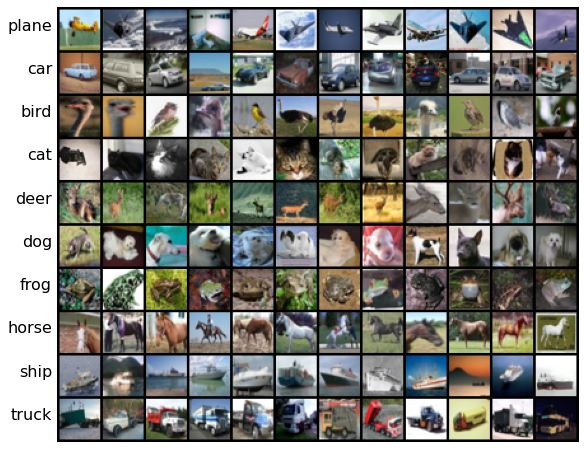

Train data shape:  torch.Size([40000, 3073])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3073])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3073])
Test labels shape:  torch.Size([10000])


In [9]:
# Invoke the above function to get our data. 
import eecs598

eecs598.reset_seed(0)
data_dict = eecs598.data.preprocess_cifar10(bias_trick=True, cuda=False, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# SVM Classifier

In this section, you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In Assignment 2, you SHOULD NOT use ".to()" or ".cuda()" in each implementation block. Otherwise, your implementation would gives you an error in Autograder end.

First, we will test the naive version of svm loss in `linear_classifier.py`. Let's first try the naive implementation of the loss we provided for you. You will get 9.000197. (Note: we've provided the `loss` part of the `svm_loss_naive` function, so you don't need to re-implement in `svm_loss_naive`. However, if your loss value doesn't match, then please report this to [Piazza](https://piazza.com/class/ke3a8m6u5wx647))

In [10]:
import eecs598
from linear_classifier import svm_loss_naive

eecs598.reset_seed(0)
# generate a random SVM weight tensor of small numbers
W = torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device) * 0.0001 

loss, _grad_ = svm_loss_naive(W, data_dict['X_val'], data_dict['y_val'], 0.000005)
print('loss: %f' % (loss, ))

loss: 9.001455


The `_grad_` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`, by filing out the TODO blocks. You will find it helpful to interleave your new code inside the existing function.

To check that you have implemented the gradient correctly, we will use **numeric gradient checking**: we will use a finite differences approach to numerically estimate the gradient of the forward pass, and compare this numeric gradient to the analytic gradient that you implemented.

We have provided a function `eecs598.grad.grad_check_sparse` to help with numeric gradient checking. You can learn more about this function using the `help` command:

In [11]:
import eecs598
help(eecs598.grad.grad_check_sparse)

Help on function grad_check_sparse in module eecs598.grad:

grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-07)
    Utility function to perform numeric gradient checking. We use the centered
    difference formula to compute a numeric derivative:
    
    f'(x) =~ (f(x + h) - f(x - h)) / (2h)
    
    Rather than computing a full numeric gradient, we sparsely sample a few
    dimensions along which to compute numeric derivatives.
    
    Inputs:
    - f: A function that inputs a torch tensor and returns a torch scalar
    - x: A torch tensor giving the point at which to evaluate the numeric gradient
    - analytic_grad: A torch tensor giving the analytic gradient of f at x
    - num_checks: The number of dimensions along which to check
    - h: Step size for computing numeric derivatives



In [12]:
x_demo = torch.tensor(range(24)).reshape(1,3,4,2)
for i in range(10):
  ix = tuple([random.randrange(m) for m in x_demo.shape])
  print(ix)

(0, 1, 0, 1)
(0, 1, 2, 1)
(0, 2, 1, 0)
(0, 0, 0, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 1)
(0, 2, 2, 0)
(0, 0, 3, 0)
(0, 1, 1, 1)


Now run the following to perform numeric gradient checking on the gradients of your SVM loss. You should see relative errors less than `1e-5`.

In [13]:
import eecs598
from linear_classifier import svm_loss_naive

# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Use a random W and a minibatch of data from the val set for gradient checking
# For numeric gradient checking it is a good idea to use 64-bit floating point
# numbers for increased numeric precision; however when actually training models
# we usually use 32-bit floating point numbers for increased speed.
eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
batch_size = 64
X_batch = data_dict['X_val'][:batch_size]
y_batch = data_dict['y_val'][:batch_size]

# Compute the loss and its gradient at W.
# YOUR_TURN: implement the gradient part of 'svm_loss_naive' function in "linear_classifier.py"
_, grad = svm_loss_naive(W, X_batch, y_batch, reg=0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_numerical = eecs598.grad.grad_check_sparse(f, W, grad)

numerical: 0.031599 analytic: 0.031599, relative error: 3.284032e-08
numerical: 0.111444 analytic: 0.111444, relative error: 1.584046e-07
numerical: 0.011204 analytic: 0.011204, relative error: 1.860695e-07
numerical: -0.046128 analytic: -0.046128, relative error: 2.741202e-07
numerical: 0.071948 analytic: 0.071948, relative error: 2.343481e-08
numerical: 0.025688 analytic: 0.025688, relative error: 6.774323e-07
numerical: 0.185388 analytic: 0.185388, relative error: 6.482448e-08
numerical: -0.021740 analytic: -0.021740, relative error: 7.159385e-08
numerical: -0.159613 analytic: -0.159613, relative error: 8.523654e-09
numerical: 0.092690 analytic: 0.092690, relative error: 1.126152e-07


Let's do the gradient check once again with regularization turned on. (You didn't forget the regularization gradient, did you?)

You should see relative errors less than `1e-5`.

In [14]:
import eecs598
from linear_classifier import svm_loss_naive

# Use a minibatch of data from the val set for gradient checking
eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
batch_size = 64
X_batch = data_dict['X_val'][:batch_size]
y_batch = data_dict['y_val'][:batch_size]

# Compute the loss and its gradient at W.
# YOUR_TURN: check your 'svm_loss_naive' implementation with different 'reg'
_, grad = svm_loss_naive(W, X_batch, y_batch, reg=1e3) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=1e3)[0]
grad_numerical = eecs598.grad.grad_check_sparse(f, W, grad)

numerical: 0.077269 analytic: 0.077269, relative error: 3.692407e-08
numerical: 0.388860 analytic: 0.388860, relative error: 5.582723e-08
numerical: -0.150628 analytic: -0.150628, relative error: 3.446075e-08
numerical: -0.148681 analytic: -0.148681, relative error: 7.277165e-08
numerical: -0.075842 analytic: -0.075842, relative error: 1.601786e-08
numerical: -0.004539 analytic: -0.004538, relative error: 4.379537e-06
numerical: 0.376041 analytic: 0.376041, relative error: 2.567064e-08
numerical: 0.032924 analytic: 0.032924, relative error: 9.885950e-08
numerical: 0.105138 analytic: 0.105138, relative error: 1.886019e-08
numerical: -0.033852 analytic: -0.033852, relative error: 3.237507e-07


Now, let's implement vectorized version of SVM: `svm_loss_vectorized`. It should compute the same inputs and outputs as the naive version before, but it should involve **no explicit loops**.

Let's first check the speed and performance bewteen the non-vectorized and the vectorized version. You should see a 15-120x speedup. PyTorch does some extra setup the first time you run CUDA code, so **you may need to run this cell more than once to see the desired speedup**.

(Note: It may have some difference, but should be less than 1e-6)

In [15]:
import eecs598
from linear_classifier import svm_loss_naive, svm_loss_vectorized

# Use random weights and a minibatch of val data for gradient checking
eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
"""
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss: %e computed in %.2fms' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
# YOUR_TURN: implement the loss part of 'svm_loss_vectorized' function in "linear_classifier.py"
loss_vec, _ = svm_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss: %e computed in %.2fms' % (loss_vec, ms_vec))
"""
loss_naive,_ = svm_loss_naive(W, X_batch, y_batch, reg)
loss_vec,_ = svm_loss_vectorized(W, X_batch, y_batch, reg)
# The losses should match but your vectorized implementation should be much faster.
print('Difference: %.2e' % (loss_naive - loss_vec))
#print('Speedup: %.2fX' % (ms_naive / ms_vec))

Difference: -1.78e-15


Then, let's compute the gradient of the loss function. We can check the difference of gradient as well. (The error should be less than 1e-6)

Now implement a vectorized version of the gradient computation in `svm_loss_vectorize` above. Run the cell below to compare the gradient of your naive and vectorized implementations. The difference between the gradients should be less than `1e-6`, and the vectorized version should run 15-120x faster.


In [16]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.

import eecs598
from linear_classifier import svm_loss_naive, svm_loss_vectorized

# Use random weights and a minibatch of val data for gradient checking
eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
"""
torch.cuda.synchronize()
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss and gradient: computed in %.2fms' % ms_naive)

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
# YOUR_TURN: implement the gradient part of 'svm_loss_vectorized' function in "linear_classifier.py"
_, grad_vec = svm_loss_vectorized(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss and gradient: computed in %.2fms' % ms_vec)
"""
# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a tensor, so
# we use the Frobenius norm to compare them.
_,grad_naive = svm_loss_naive(W, X_batch, y_batch, reg)
_,grad_vec = svm_loss_vectorized(W, X_batch, y_batch, reg)
grad_difference = torch.norm(grad_naive - grad_vec, p='fro')
print('Gradient difference: %.2e' % grad_difference)
#print('Speedup: %.2fX' % (ms_naive / ms_vec))

Gradient difference: 2.08e-14


Now that we have an efficient vectorized implementation of the SVM loss and its gradient, we can implement a training pipeline for linear classifiers.

Please complete the implementation of `train_linear_classifier` in `linear_classifer.py`.


Once you have implemented the training function, run the following cell to train a linear classifier using some default hyperparameters:

(You should see a final loss close to 9.0, and your training loop should run in about two seconds)

In [17]:
import eecs598
from linear_classifier import svm_loss_vectorized, train_linear_classifier

# fix random seed before we perform this operation
eecs598.reset_seed(0)
"""
torch.cuda.synchronize()
tic = time.time()
"""
# YOUR_TURN: Implement how to construct the batch, 
#            and how to update the weight in 'train_linear_classifier'
W, loss_hist = train_linear_classifier(svm_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=3e-11, reg=2.5e4,
                                       num_iters=1500, verbose=True)
"""
torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))
"""

iteration 0 / 1500: loss 9.000796
iteration 100 / 1500: loss 9.000782
iteration 200 / 1500: loss 9.000793
iteration 300 / 1500: loss 9.000787
iteration 400 / 1500: loss 9.000789
iteration 500 / 1500: loss 9.000780
iteration 600 / 1500: loss 9.000795
iteration 700 / 1500: loss 9.000778
iteration 800 / 1500: loss 9.000782
iteration 900 / 1500: loss 9.000763
iteration 1000 / 1500: loss 9.000791
iteration 1100 / 1500: loss 9.000787
iteration 1200 / 1500: loss 9.000772
iteration 1300 / 1500: loss 9.000786
iteration 1400 / 1500: loss 9.000787


"\ntorch.cuda.synchronize()\ntoc = time.time()\nprint('That took %fs' % (toc - tic))\n"

A useful debugging strategy is to plot the loss as a function of iteration number. In this case it seems our hyperparameters are not good, since the training loss is not decreasing very fast.



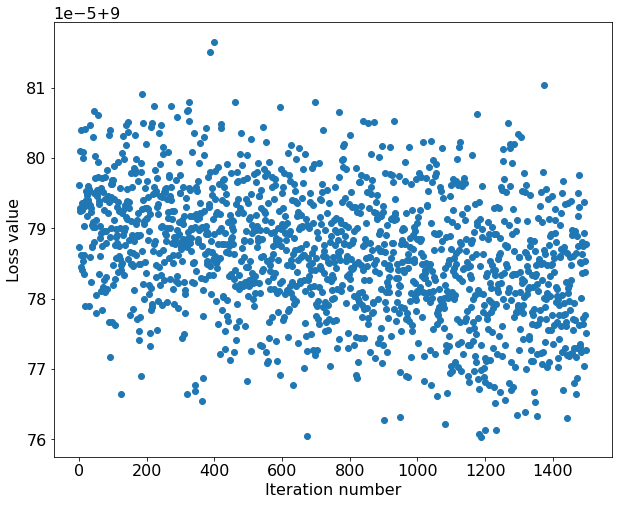

In [19]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Then, let's move on to the prediction stage. We can evaluate the performance our trained model on both the training and validation set. You should see validation accuracy less than 20%.

In [20]:
import eecs598
from linear_classifier import predict_linear_classifier

# fix random seed before we perform this operation
eecs598.reset_seed(0)

# evaluate the performance on both the training and validation set
# YOUR_TURN: Implement how to make a prediction with the trained weight 
#            in 'predict_linear_classifier'
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('Training accuracy: %.2f%%' % train_acc)

y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

Training accuracy: 8.91%
Validation accuracy: 9.08%


Unfortunately, the performance of our initial model is quite bad. To find a better hyperparamters, we first modulized the functions that we've implemented as LinearSVM.

Now, please use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths.

To get full credit for the assignment your best model found through cross-validation should achieve an accuracy of at least 37% on the validation set.

(Our best model got over 38.1% -- did you beat us?)

In [21]:
import os
import eecs598
from linear_classifier import LinearSVM, svm_get_search_params, test_one_param_set

# YOUR_TURN: find the best learning_rates and regularization_strengths combination
#            in 'svm_get_search_params'
learning_rates, regularization_strengths = svm_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)

####
# It is okay to comment out the following conditions when you are working on svm_get_search_params.
# But, please do not forget to reset back to the original setting once you are done.
if num_models > 25:
  raise Exception("Please do not test/submit more than 25 items at once")
elif num_models < 5:
  raise Exception("Please present at least 5 parameter sets in your final ipynb")
####


i = 0
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (train_acc, val_acc). 
results = {}
best_val = -1.0   # The highest validation accuracy that we have seen so far.
best_svm_model = None # The LinearSVM object that achieved the highest validation rate.
num_iters = 2000 # number of iterations

for lr in learning_rates:
  for reg in regularization_strengths:
    i += 1
    print('Training SVM %d / %d with learning_rate=%e and reg=%e'
          % (i, num_models, lr, reg))
    
    eecs598.reset_seed(0)
    # YOUR_TURN: implement a function that gives the trained model with 
    #            train/validation accuracies in 'test_one_param_set'
    #            (note: this function will be used in Softmax Classifier section as well)
    cand_svm_model, cand_train_acc, cand_val_acc = test_one_param_set(LinearSVM(), data_dict, lr, reg, num_iters)

    if cand_val_acc > best_val:
      best_val = cand_val_acc
      best_svm_model = cand_svm_model # save the svm
    results[(lr, reg)] = (cand_train_acc, cand_val_acc)


# Print out results.
for lr, reg in sorted(results):
  train_acc, val_acc = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_acc, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# save the best model
path = os.path.join(GOOGLE_DRIVE_PATH, 'svm_best_model.pt')
best_svm_model.save(path)

Training SVM 1 / 25 with learning_rate=2.000000e-03 and reg=5.000000e-02
Training SVM 2 / 25 with learning_rate=2.000000e-03 and reg=8.000000e-02
Training SVM 3 / 25 with learning_rate=2.000000e-03 and reg=1.000000e-01
Training SVM 4 / 25 with learning_rate=2.000000e-03 and reg=2.000000e-01
Training SVM 5 / 25 with learning_rate=2.000000e-03 and reg=3.000000e-01
Training SVM 6 / 25 with learning_rate=5.000000e-03 and reg=5.000000e-02
Training SVM 7 / 25 with learning_rate=5.000000e-03 and reg=8.000000e-02
Training SVM 8 / 25 with learning_rate=5.000000e-03 and reg=1.000000e-01
Training SVM 9 / 25 with learning_rate=5.000000e-03 and reg=2.000000e-01
Training SVM 10 / 25 with learning_rate=5.000000e-03 and reg=3.000000e-01
Training SVM 11 / 25 with learning_rate=7.000000e-03 and reg=5.000000e-02
Training SVM 12 / 25 with learning_rate=7.000000e-03 and reg=8.000000e-02
Training SVM 13 / 25 with learning_rate=7.000000e-03 and reg=1.000000e-01
Training SVM 14 / 25 with learning_rate=7.00000

Visualize the cross-validation results. You can use this as a debugging tool -- after examining the cross-validation results here, you may want to go back and rerun your cross-validation from above.

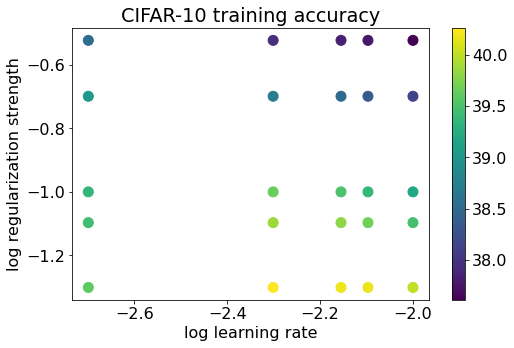

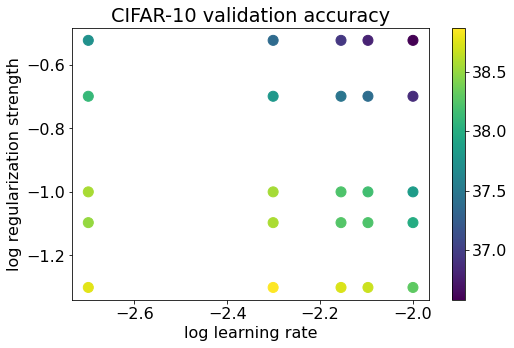

In [22]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

In [24]:
my_own_best,train_acc,test_acc = test_one_param_set(LinearSVM(), data_dict, 5e-3, 5e-2 , num_iters=3000)

Evaluate the best svm on test set. To get full credit for the assignment you should achieve a test-set accuracy above 35%.

(Our best was over 39.1% -- did you beat us?)

In [27]:
import eecs598

eecs598.reset_seed(0)
y_test_pred = best_svm_model.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).double())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.388700


In [28]:
import eecs598

eecs598.reset_seed(0)
y_test_pred = my_own_best.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).double())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.390800


Visualize the learned weights for each class. Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.

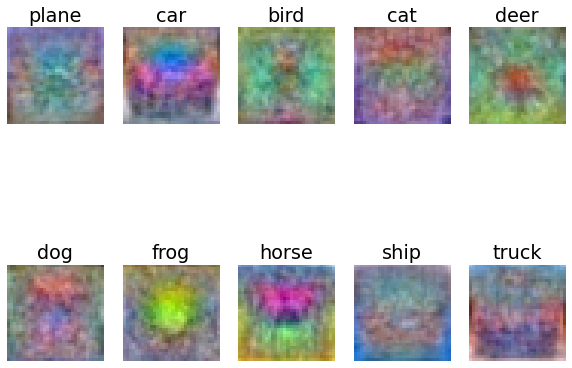

In [29]:
w = best_svm_model.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])

# Softmax Classifier

Similar to the SVM, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

As noted in the SVM section, you SHOULD NOT use ".to()" or ".cuda()" in each implementation block.

First, let's start from implementing the naive softmax loss function with nested loops in `softmax_loss_naive` function.

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix and no regularization. You should see loss near log(10) = 2.3

In [42]:
import eecs598
from linear_classifier import softmax_loss_naive

eecs598.reset_seed(0)
# Generate a random softmax weight tensor and use it to compute the loss.
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# YOUR_TURN: Complete the implementation of softmax_loss_naive and implement 
# a (naive) version of the gradient that uses nested loops.
loss, _ = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

# As a rough sanity check, our loss should be something close to log(10.0).
print('loss: %f' % loss)
print('sanity check: %f' % (math.log(10.0)))

loss: 2.302658
sanity check: 2.302585


Next, we use gradient checking to debug the analytic gradient of our naive softmax loss function. If you've implemented the gradient correctly, you should see relative errors less than `1e-5`.


In [43]:
import eecs598
from linear_classifier import softmax_loss_naive

eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# YOUR_TURN: Complete the implementation of softmax_loss_naive and implement 
# a (naive) version of the gradient that uses nested loops.
_, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
eecs598.grad.grad_check_sparse(f, W, grad, 10)

numerical: 0.003037 analytic: 0.003037, relative error: 1.908649e-06
numerical: 0.006320 analytic: 0.006320, relative error: 3.245704e-07
numerical: 0.005323 analytic: 0.005324, relative error: 5.087487e-07
numerical: 0.002583 analytic: 0.002583, relative error: 6.976762e-07
numerical: 0.007509 analytic: 0.007509, relative error: 6.336622e-07
numerical: 0.006408 analytic: 0.006408, relative error: 6.447249e-08
numerical: 0.011408 analytic: 0.011408, relative error: 7.993262e-08
numerical: 0.001836 analytic: 0.001836, relative error: 3.286190e-06
numerical: -0.014689 analytic: -0.014689, relative error: 1.950062e-08
numerical: -0.005180 analytic: -0.005180, relative error: 2.147900e-07


Let's perform another gradient check with regularization enabled. Again you should see relative errors less than `1e-5`.

In [45]:
import eecs598
from linear_classifier import softmax_loss_naive

eecs598.reset_seed(128)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 10.0

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# YOUR_TURN: Complete the gradient compuation part of softmax_loss_naive 
_, grad = softmax_loss_naive(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
eecs598.grad.grad_check_sparse(f, W, grad, 10)

numerical: -0.000315 analytic: -0.000315, relative error: 7.667359e-08
numerical: 0.008412 analytic: 0.008412, relative error: 1.323490e-08
numerical: 0.004886 analytic: 0.004886, relative error: 3.969193e-07
numerical: -0.000105 analytic: -0.000105, relative error: 1.395932e-05
numerical: 0.008074 analytic: 0.008074, relative error: 2.016509e-07
numerical: 0.005279 analytic: 0.005279, relative error: 3.536557e-07
numerical: 0.013720 analytic: 0.013720, relative error: 8.753114e-08
numerical: 0.001178 analytic: 0.001178, relative error: 5.671332e-07
numerical: -0.015923 analytic: -0.015923, relative error: 3.176846e-08
numerical: -0.005052 analytic: -0.005052, relative error: 5.752629e-07


Then, let's move on to the vectorized form: `softmax_loss_vectorized`.

Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be much faster.

The differences between the naive and vectorized losses and gradients should both be less than `1e-6`, and your vectorized implementation should be at least 20x faster than the naive implementation.

In [48]:
import eecs598
from linear_classifier import softmax_loss_naive, softmax_loss_vectorized

eecs598.reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 0.05

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]
"""
# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
# YOUR_TURN: Complete the implementation of softmax_loss_vectorized
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))
"""
# we use the Frobenius norm to compare the two versions of the gradient.
loss_naive, grad_navie = softmax_loss_naive(W, X_batch, y_batch, reg)
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
#print('Speedup: %.2fX' % (ms_naive / ms_vec))

Loss difference: 4.44e-16
Gradient difference: 1.66e+01


In [50]:
eecs598.reset_seed(128)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 10.0

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# YOUR_TURN: Complete the gradient compuation part of softmax_loss_naive 
_, grad = softmax_loss_vectorized(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_vectorized(w, X_batch, y_batch, reg)[0]
eecs598.grad.grad_check_sparse(f, W, grad, 10)

numerical: -0.000315 analytic: -0.000315, relative error: 3.450800e-06
numerical: 0.008412 analytic: 0.008412, relative error: 1.187421e-07
numerical: 0.004886 analytic: 0.004886, relative error: 5.753897e-08
numerical: -0.000105 analytic: -0.000105, relative error: 3.387042e-06
numerical: 0.008074 analytic: 0.008074, relative error: 6.413789e-08
numerical: 0.005279 analytic: 0.005279, relative error: 2.773304e-07
numerical: 0.013720 analytic: 0.013720, relative error: 6.609164e-09
numerical: 0.001178 analytic: 0.001178, relative error: 3.754565e-07
numerical: -0.015923 analytic: -0.015923, relative error: 3.176846e-08
numerical: -0.005052 analytic: -0.005052, relative error: 3.038541e-07


Let's check that your implementation of the softmax loss is numerically stable.

If either of the following print `nan` then you should double-check the numeric stability of your implementations.

In [51]:
import eecs598
from linear_classifier import softmax_loss_naive, softmax_loss_vectorized

eecs598.reset_seed(0)
device = data_dict['X_train'].device
dtype = data_dict['X_train'].dtype
D = data_dict['X_train'].shape[1]
C = 10

# YOUR_TURN??: train_linear_classifier should be same as what you've implemented in the SVM section
W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_naive, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


iteration 0 / 1: loss 768250002.302585
iteration 0 / 1: loss 768250002.302585


Now lets train a softmax classifier with some default hyperparameters:


In [52]:
import eecs598
from linear_classifier import softmax_loss_vectorized

eecs598.reset_seed(0)
"""
torch.cuda.synchronize()
tic = time.time()
"""
# YOUR_TURN??: train_linear_classifier should be same as what you've implemented in the SVM section
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-10, reg=2.5e4,
                                       num_iters=1500, verbose=True)
"""
torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))
"""

iteration 0 / 1500: loss 2.303364
iteration 100 / 1500: loss 2.303362
iteration 200 / 1500: loss 2.303362
iteration 300 / 1500: loss 2.303361
iteration 400 / 1500: loss 2.303360
iteration 500 / 1500: loss 2.303359
iteration 600 / 1500: loss 2.303360
iteration 700 / 1500: loss 2.303357
iteration 800 / 1500: loss 2.303357
iteration 900 / 1500: loss 2.303354
iteration 1000 / 1500: loss 2.303356
iteration 1100 / 1500: loss 2.303355
iteration 1200 / 1500: loss 2.303353
iteration 1300 / 1500: loss 2.303354
iteration 1400 / 1500: loss 2.303353


"\ntorch.cuda.synchronize()\ntoc = time.time()\nprint('That took %fs' % (toc - tic))\n"

Plot the loss curve:

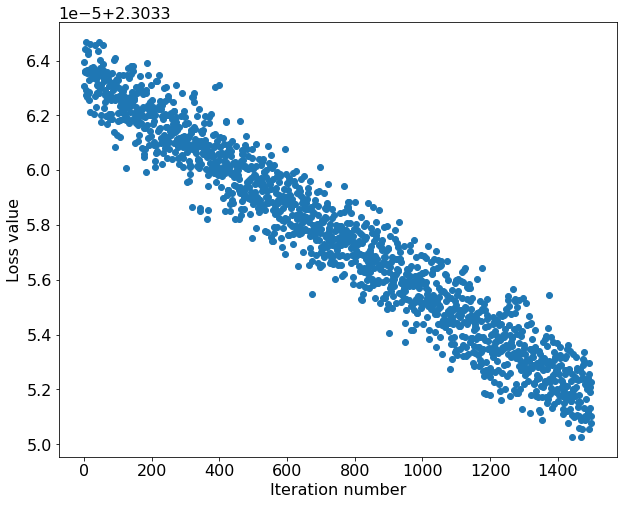

In [53]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's compute the accuracy of current model. It should be less than 10%.

In [54]:
import eecs598
from linear_classifier import predict_linear_classifier

eecs598.reset_seed(0)

# evaluate the performance on both the training and validation set
# YOUR_TURN??: predict_linear_classifier should be same as what you've implemented before, in the SVM section
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 8.59%
validation accuracy: 8.67%


Now use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths.

To get full credit for the assignment, your best model found through cross-validation should achieve an accuracy above 0.37 on the validation set.

(Our best model was above 39.8% -- did you beat us?)

In [57]:
import os
import eecs598
from linear_classifier import Softmax, softmax_get_search_params, test_one_param_set

# YOUR_TURN: find the best learning_rates and regularization_strengths combination
#            in 'softmax_get_search_params'
learning_rates, regularization_strengths = softmax_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)

####
# It is okay to comment out the following conditions when you are working on svm_get_search_params.
# But, please do not forget to reset back to the original setting once you are done.
if num_models > 25:
  raise Exception("Please do not test/submit more than 25 items at once")
elif num_models < 5:
  raise Exception("Please present at least 5 parameter sets in your final ipynb")
####


i = 0
# As before, store your cross-validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples (train_acc, val_acc)
results = {}
best_val = -1.0   # The highest validation accuracy that we have seen so far.
best_softmax_model = None # The Softmax object that achieved the highest validation rate.
num_iters = 2000 # number of iterations

for lr in learning_rates:
  for reg in regularization_strengths:
    i += 1
    print('Training Softmax %d / %d with learning_rate=%e and reg=%e'
          % (i, num_models, lr, reg))
    
    eecs598.reset_seed(0)
    cand_softmax_model, cand_train_acc, cand_val_acc = test_one_param_set(Softmax(), data_dict, lr, reg, num_iters)

    if cand_val_acc > best_val:
      best_val = cand_val_acc
      best_softmax_model = cand_softmax_model # save the classifier
      best_lr = lr
      best_reg = reg
    results[(lr, reg)] = (cand_train_acc, cand_val_acc)


# Print out results.
for lr, reg in sorted(results):
  train_acc, val_acc = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_acc, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# save the best model
path = os.path.join(GOOGLE_DRIVE_PATH, 'softmax_best_model.pt')
best_softmax_model.save(path)

Training Softmax 1 / 12 with learning_rate=1.000000e-02 and reg=5.000000e-03
Training Softmax 2 / 12 with learning_rate=1.000000e-02 and reg=1.000000e-02
Training Softmax 3 / 12 with learning_rate=1.000000e-02 and reg=5.000000e-02
Training Softmax 4 / 12 with learning_rate=1.000000e-02 and reg=8.000000e-02
Training Softmax 5 / 12 with learning_rate=2.000000e-02 and reg=5.000000e-03
Training Softmax 6 / 12 with learning_rate=2.000000e-02 and reg=1.000000e-02
Training Softmax 7 / 12 with learning_rate=2.000000e-02 and reg=5.000000e-02
Training Softmax 8 / 12 with learning_rate=2.000000e-02 and reg=8.000000e-02
Training Softmax 9 / 12 with learning_rate=3.000000e-02 and reg=5.000000e-03
Training Softmax 10 / 12 with learning_rate=3.000000e-02 and reg=1.000000e-02
Training Softmax 11 / 12 with learning_rate=3.000000e-02 and reg=5.000000e-02
Training Softmax 12 / 12 with learning_rate=3.000000e-02 and reg=8.000000e-02
lr 1.000000e-02 reg 5.000000e-03 train accuracy: 40.492500 val accuracy: 

Run the following to visualize your cross-validation results:

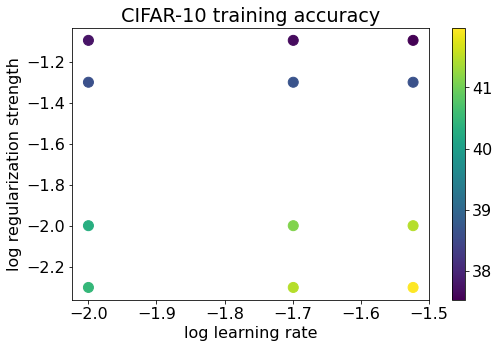

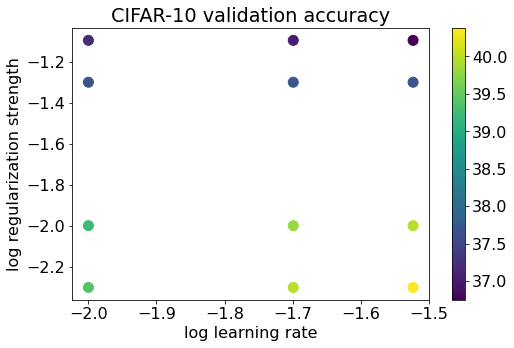

In [58]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Them, evaluate the performance of your best model on test set. To get full credit for this assignment you should achieve a test-set accuracy above 0.36.

(Our best was just around 39.9% -- did you beat us?)



In [60]:
y_test_pred = best_softmax_model.predict(data_dict['X_test'])
test_accuracy = 100.0 * torch.mean((data_dict['y_test'] == y_test_pred).double())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 40.380000


Finally, let's visualize the learned weights for each class

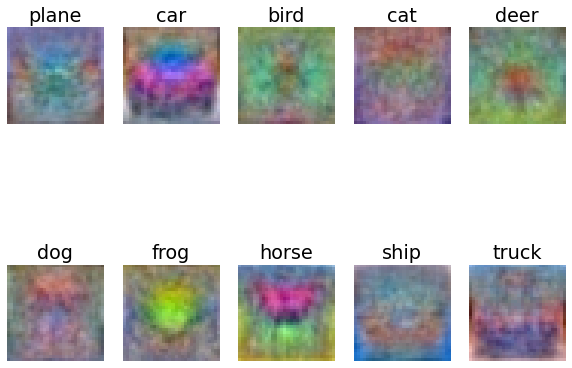

In [61]:
w = best_softmax_model.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])